# Chemical systems
> Chemical process examples.

In [ ]:
#| default_exp examples.chemistry

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import warnings
from simbox.basics import *

## Utils

In [ ]:
#| export
def draw_ellipse(ax=None, center=[0,0], A=np.eye(2), rho=1, color='b', figsize=(3,3)):
    "Draw an ellipse defined by a positive-definite matrix `A` and squared radius `rho`."
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    l = np.linspace(0,2*np.pi,100)
    pts = np.vstack([np.cos(l), np.sin(l)]) * np.sqrt(rho)
    pts = pts.T @ np.linalg.inv(np.linalg.cholesky(A)) + center
    ax.plot(*pts.T, '-', c=color)

## CSTR

This example uses the CSTR chemical reactor. The dynamics being
$$
\begin{split}
\frac{d C_A}{dt} &= \frac{F}{V}(C_{A0} - C_A) - kC_A^2,\\
\frac{d T}{dt} &= \frac{F}{V}(T_0 - T) + \frac{-\Delta H}{\rho_L C_p}kC_A^2 + \frac{Q}{\rho_L C_p V},
\end{split}
$$
where $k = k_0\exp(-\frac{E}{RT})$. We use the default values for the parameters from the paper.

![](./fig/CSTR-params.png){width=380}

__ref__:

- [Wu Zhe. "Machine-learning-based predictive control of nonlinear processes. Part II: Computational implementation", 2019](https://bpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/3/15435/files/2021/12/Wu_2019f.pdf).

In [ ]:
#| export
class CSTR(ParamsMixin, LeafSystem):
    "Continuous Stirred Tank Reactor."
    named_inp    = namedview('input', ('C_A0','Q'))
    named_state  = namedview('state', ('C_A','T'))
    named_params = namedview('params', ('k0','rho_L','C_p','R','E','F','T0','V','dH'))
    _param_units = ('m^3/kmol/hr', 'kg/m^3', 'kJ/kg/K', 'kJ/kmol/K', 'kJ/kmol', 'm^3/hr', 'K', 'm^3', 'kJ/kmol')
    def __init__(self, set_params_mannually: bool=False, params: Union[list[float], np.ndarray]=None):
        super().__init__()
        self.set_name('CSTR')
        self._numeric_params = BasicVector([8.46e6, 1000., .231, 8.314, 5e4, 5., 300., 1., -1.15e4]) # Default values
        state = self.DeclareContinuousState(2)
        self.DeclareVectorInputPort(name='u', size=2)
        self.DeclareStateOutputPort('y=x', state)
        if set_params_mannually: self._update_params() # Set parameter values mannually
        if params is not None and not set_params_mannually: # Set parameter values from a vector
            assert len(params) == len(self._param_units), f"Expect `params` of length {len(self._param_units)}, but got {len(params)}."
            self._numeric_params = BasicVector(params)
        self.DeclareNumericParameter(self._numeric_params)
        # Display parameters
        self.params
    
    @staticmethod
    def _dyn(t,x,u,p,xd):
        FV = p.F/p.V
        k0_exp_C_A2 = p.k0 * np.exp(-p.E/p.R/x.T) * x.C_A**2
        # x_dot
        xd.C_A = FV * (u.C_A0 - x.C_A) - k0_exp_C_A2
        xd.T   = FV * (p.T0 - x.T) - p.dH/p.rho_L/p.C_p * k0_exp_C_A2 + u.Q/p.rho_L/p.C_p/p.V
    
    def DoCalcTimeDerivatives(self, ctx, outp):
        x = self.named_state(ctx.get_continuous_state_vector().get_value())
        u = self.named_inp(self.get_input_port(0).Eval(ctx))
        xd = self.named_state(np.zeros(2))
        p = self.named_params(ctx.get_numeric_parameter(0).get_value())
        self._dyn(None, x, u, p, xd)
        outp.get_mutable_vector().SetFromVector(xd[:])
    
    @staticmethod
    def plot_log(log, inp_log=None, axs=None, figsize=(9,2),
                 labels=[r'$C_A-C_{A_s} (kmol/m^3)$', r'$T-T_s (K)$'],
                 labels_inp=[r'$C_{A0}-C_{A0_s} (kmol/m^3)$', r'$Q-Q_s (kJ/hr)$']):
        if axs is None:
            fig,axs = plt.subplots(1,2 if inp_log is None else 3,figsize=figsize)
        colors = ['C0','C1']
        ts,data = log
        axs[0].plot(ts, data[0],'x-',c=colors[0])
        axs[0].set_xlabel('t (hr)')
        axs[0].set_ylabel(labels[0], color=colors[0])
        axs[0].tick_params(axis='y', labelcolor=colors[0])
        a2 = axs[0].twinx()
        a2.plot(ts, data[1],'x-',c=colors[1])
        a2.set_ylabel(labels[1], color=colors[1])
        a2.tick_params(axis='y', labelcolor=colors[1])
        
        axs[1].plot(data[0], data[1], 'x-', c='k')
        axs[1].plot(data[0][0], data[1][0], 's', c='C2')  # start point
        axs[1].set_xlabel(labels[0])
        axs[1].set_ylabel(labels[1])

        if inp_log is not None:
            ts,data = inp_log
            axs[2].step(ts, data[0],'-',c=colors[0], where='pre')
            axs[2].set_xlabel('t (hr)')
            axs[2].set_ylabel(labels_inp[0], color=colors[0])
            axs[2].tick_params(axis='y', labelcolor=colors[0])
            a2 = axs[2].twinx()
            a2.step(ts, data[1],'--',c=colors[1], where='pre')
            a2.set_ylabel(labels_inp[1], color=colors[1])
            a2.tick_params(axis='y', labelcolor=colors[1])
        try: fig.tight_layout()
        except: pass

In [ ]:
sys = CSTR()
cstr = SimpleCSimBox(sys, True, True, log_shift_state=True, log_period=0.05)

params(k0=8460000.0, rho_L=1000.0, C_p=0.231, R=8.314, E=50000.0, F=5.0, T0=300.0, V=1.0, dH=-11500.0)


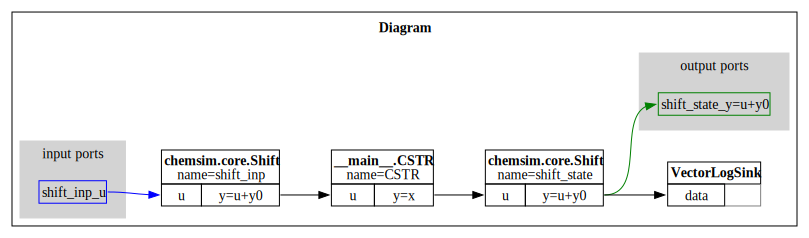

In [ ]:
#| eval: false
viz_diagram(cstr.dgm)

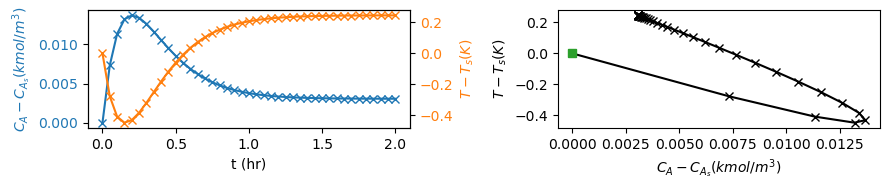

In [ ]:
ref_inp = [4,0.]
ref_state = [1.22, 438]
cstr.initialize([0,0], ref_state, ref_inp, ref_state, True)
cstr.sim.AdvanceTo(2)
cstr.sys.plot_log(cstr.get_state_log_items())

:::{.callout-tip apparance='simple' title="Integration with `scipy`"}
`SimpleCSimBox` has a method `extract_dyn` to extract the _dynamical equation_ of `sys` (with its input `u` shifted, if possible). The returned function takes three inputs, i.e. `xdot = f(t,x,u)`. By partially fixing `u`, we can call any preferable integration method, e.g. `solve_ivp` from `scipy.integrate` to get the trajectory of states in time.
:::

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
u = [0,0.]
_f = lambda t,x: cstr.extract_dyn()(t,x,u)
ts = np.linspace(0,2,40)
res = solve_ivp(_f, [0,2], ref_state, t_eval=ts, method='DOP853')

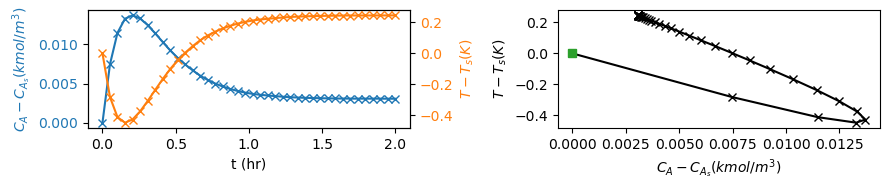

In [ ]:
cstr.sys.plot_log((ts, (res.y.T-ref_state).T))  # shift the state

## PFR

The plug flow reactor (PFR) is governed by the following PDE
$$
\begin{split}
\frac{\partial C_A}{\partial t} &= -u\frac{\partial C_A}{\partial z} - kC_A\\
\frac{\partial T}{\partial t} &= -u\frac{\partial T}{\partial z} + \frac{-\Delta H}{\rho_L C_P}kC_A + \frac{U}{\rho_L C_P A} A_t(T_c - T)
\end{split}
$$
where $k = k_0\exp(-\frac{E}{RT})$.

In [ ]:
#|hide
T0_s = 440 # inlet temperature
T_s = 423 # steady-state reactor temperature                
CA0_s = 1.6 # steady-state inlet concentration of A
CA_s = 0.11 # steady-state reactor concentration of A         
Tc_s = 293 # steady state cooling temperature
N = 10     # number of points to discretize the reactor 

In [ ]:
#|hide
class PFR(ParamsMixin, LeafSystem):
    "Plug Flow Reactor. Parameters taken Siettos et al.'s work (1998)"
    named_inp    = namedview('input', ('T_c'))
    named_state  = namedview('state', ('C_A','T'))
    named_params = namedview('params', ('k0','rho_L','C_p', 'E_by_R', 'dH', 'u', 'A', 'A_t', 'U'))
    _param_units = ('m^3/kmol/hr', 'kg/m^3', 'kJ/kg/K', 'K', 'kJ/kmol', 'm/hr', 'm^2', 'm^2', 'kJ/m^3/K/hr')
    def __init__(self, use_default_params: bool=True):
        super().__init__()
        self.set_name('PFR')
        self._numeric_params = BasicVector([3.34e8, 47., 25., 8600, -4.4e4, 2., 0.002, 0.01, 25])
    
    @staticmethod
    def _dyn(t,x,u,p,xd): pass
    
    def DoCalcTimeDerivatives(self, ctx, outp): pass
    
    @staticmethod
    def plot_log(ts, data, axs=None, figsize=(5,2)): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()